In [1]:
# for figure 2
# results contains the real-world workload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import lasso_path, enet_path
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

import nbimporter
from helpers import expr_data
from helpers import scale_data
from helpers import similarity

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(53711)
random.seed(53711)

#### Load all data

In [4]:
data = expr_data.ExprData()
data.load_pickle()
data = data.fix_tpch()
# data = data.sample_data()

#### Split by SKU

In [5]:
data_by_sku = data.split_by_sku()

In [6]:
def sparse_argsort(arr):
    indices = np.nonzero(arr)[0]
    return indices[np.argsort(arr[indices])]

cpu_num=cpu16
cpu_num=cpu2
(36, 36, 29)
tpcc ['TableCardinality', 'CachedPlanSize', 'SerialDesiredMemory', 'MaxCompileMemory', 'CompileMemory', 'CPU_EFFECTIVE', 'AvgRowSize', 'CompileTime', 'CompileCPU', 'LOCK_REQ_ABS', 'StatementSubTreeCost', 'EstimateCPU', 'EstimatedAvailableMemoryGrant', 'SerialRequiredMemory', 'EstimateRows', 'StatementEstRows', 'EstimateIO', 'READ_WRITE_RATIO', 'IOPS_TOTAL', 'MEM_UTILIZATION', 'CPU_UTILIZATION', 'LOCK_WAIT_ABS', 'EstimatedRowsRead', 'EstimatedPagesCached']
tpcc ['TableCardinality', 'CachedPlanSize', 'MaxCompileMemory', 'SerialDesiredMemory', 'CompileMemory', 'AvgRowSize', 'CompileTime', 'LOCK_REQ_ABS', 'EstimatedAvailableMemoryGrant', 'CompileCPU', 'StatementSubTreeCost', 'EstimateCPU', 'EstimateRows', 'SerialRequiredMemory', 'CPU_EFFECTIVE', 'StatementEstRows', 'READ_WRITE_RATIO', 'EstimateIO', 'IOPS_TOTAL', 'MEM_UTILIZATION', 'LOCK_WAIT_ABS', 'CPU_UTILIZATION', 'EstimatedRowsRead']
tpch ['EstimateCPU', 'READ_WRITE_RATIO', 'MaxCompileMemory', 'St

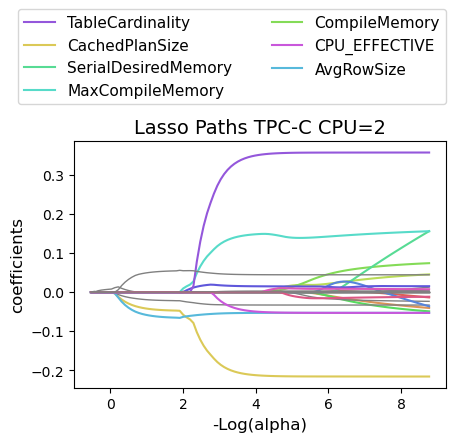

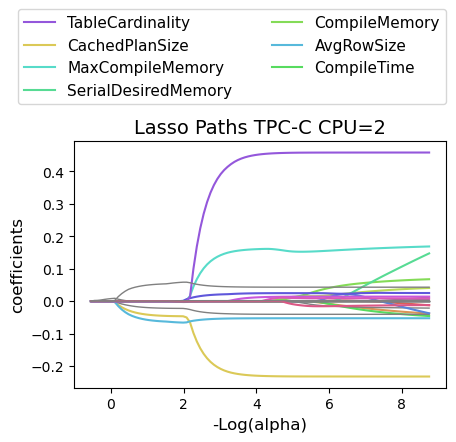

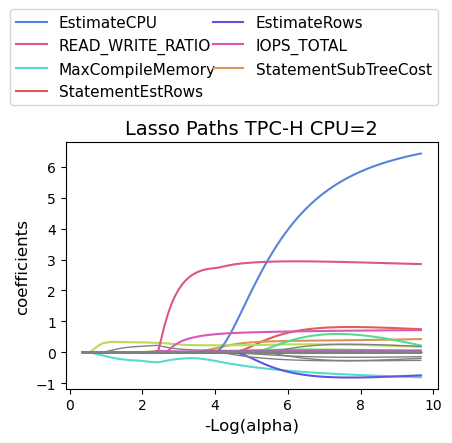

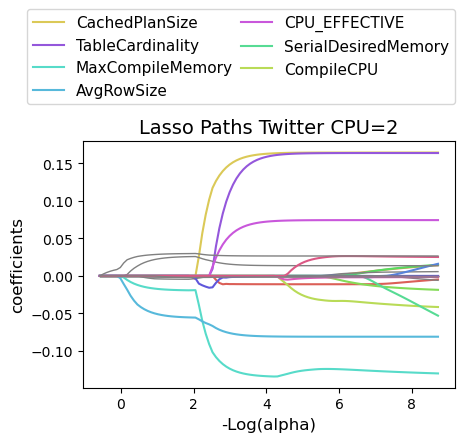

cpu_num=cpu4
cpu_num=cpu8
cpu_num=ter5
cpu_num=terx
cpu_num=tery


In [8]:
NUM_FEATURE = 7
for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    print(f'cpu_num={sku}')
    if 'cpu2' not in sku:
        continue
    if 'ter' in sku:
        continue
    scaler = scale_data.ScaleData()
    plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
    simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
    simi_calc.calc_bined_mtx()
    simi_calc.calc_dist_simi_matrix()
    
    # for some experiment, its distanct to others are: 
    expr_idx = 0
    
    # feature wise distance
    simi_calc.calc_featurewise_dist_by_col()
    
    expr_num = 4
    out_exprs = [1, 2, 17, 20]
    sku_dict = {}

    display_features = []
    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        # calculate label
        curr_name = curr_data.wl_names[expr_idx]
        y = [curr_name == name for name in curr_data.wl_names]
        X = simi_calc.simi_col_mtx[expr_idx]
    
        eps = 5e-10 
        alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)

        neg_log_alphas_lasso = -np.log10(alphas_lasso)
        weights = np.array([-1*abs(coef_l[-1]) for coef_l in coefs_lasso])

        orders = sparse_argsort(weights)
        feature_importance = [curr_data.feature_cols[j] for j in orders]
        print(curr_name, feature_importance)
        sku_dict[curr_name+str(i)] = {
            'weights': weights,
            'orders': orders,
            'fi': feature_importance,
            'alphas': neg_log_alphas_lasso,
            'lassos': coefs_lasso
        }
        display_features += list(orders[:NUM_FEATURE])
        
    display_features = np.unique(display_features)
    colors = sns.color_palette("hls", len(display_features))

    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        curr_name = curr_data.wl_names[expr_idx]
                    
        if curr_name == 'tpcc':
            title_name = 'TPC-C'
        elif curr_name == 'tpch':
            title_name = 'TPC-H'
        elif curr_name == 'twitter':
            title_name = 'Twitter';
        curr_name = curr_name+str(i)

        fig, ax = plt.subplots(figsize=(4.8, 3.2))
        for idx, coef_l in zip(list(range(len(curr_data.feature_cols))), sku_dict[curr_name]['lassos']):
            if idx in display_features:
                # get index 
                c_idx = np.where(display_features==idx)[0][0]
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c=colors[c_idx], label=curr_data.feature_cols[idx])
            else:
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c='gray', linewidth=1, label=curr_data.feature_cols[idx])

        ax.set_title('Lasso Paths {} CPU={}'.format(title_name, int(sku[3:])), fontsize=14)

        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]
        labels = [labels[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]

        ax.legend(handles,labels,bbox_to_anchor=(-0.15, 1.15, 1.15, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=11) # 
        ax.set_xlabel('-Log(alpha)', fontsize=12)
        ax.set_ylabel('coefficients', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

        plt.savefig(f'../figs/short_{curr_name}_lasso_path{NUM_FEATURE}_{sku}_fs.pdf', bbox_inches="tight")
        plt.show()